In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import HTML
from matplotlib import animation

%matplotlib inline

In [272]:
resdir1 = 'results/dt-var_alp-1.8_t-1.0Myr_e-100_s-80_e0-0.15_m0-10Me_p-100_r-10'
resdir2 = 'results/dt-var_alp-1.8_t-1.0Myr_e-100_s-80_e0-0.15_m0-10Me_p-100_r-8'

t_tot = 1e6
gpe = 100  
gps = 80    
e0 = 0.15
m0 = 10 

def unpack(res):
    N = pd.read_csv('%s/N.csv' %res, header=None,index_col=None)
    N_i = pd.read_csv('%s/N_i.csv' %res, header=None,index_col=None)
    N_o = pd.read_csv('%s/N_o.csv' %res, header=None,index_col=None)
    ts = pd.read_csv('%s/ts.csv' %res, header=None,index_col=None)

    steps = len(N)
    print(res, 'has', steps,'steps')

    N = N.to_numpy().reshape(steps,gpe,gps)
    N_i = N_i.to_numpy().reshape(steps,gpe,gps)
    N_o = N_o.to_numpy().reshape(steps,gpe,gps)
    ts = ts.to_numpy()
    dt = ts[1:] - ts[:-1]

    Ndot = 10**N_i - 10**N_o

    return N, N_i, N_o, Ndot, ts, dt,

N1, N_i1, N_o1, Ndot1, ts1, dt1 = unpack(resdir1)
N2, N_i2, N_o2, Ndot2, ts2, dt2 = unpack(resdir2)

results/dt-var_alp-1.8_t-1.0Myr_e-100_s-80_e0-0.15_m0-10Me_p-100_r-10 has 1016 steps
results/dt-var_alp-1.8_t-1.0Myr_e-100_s-80_e0-0.15_m0-10Me_p-100_r-8 has 1131 steps


In [273]:
sMin = -4    
sMax = 8

eMin = 0     
eMax = e0 + 0.05

size = np.linspace(sMin,sMax,gps)
eccs = np.linspace(eMin,eMax,gpe)

rho = 1
mass = np.log10(rho*1*np.pi/3) + 3*size  # log mass in g

asp_rat = (sMax-sMin)/(eMax-eMin)

A_stg = 2e7      # strength constant A in mJ (g m^2 / s^2)
B_stg = 3.3e-8   # strength constant B
s_small = 1   # size_0 of strength eq = 1 cm
alp_stg = -0.3   # strength constant alpha
bet_stg = 2      # strength constant beta

G = 4*np.pi**2
sma = 45                # semimajor axis in au
h = 1                   # disk scale height h = 1 AU
vkep = np.sqrt(G/sma) * (1.5e11/3.15e7)     # keplerian velocity in m s^-1

def qstar(s1):
    term1 = A_stg * (s1/s_small)**alp_stg
    term2 = B_stg * 2.5 * (s1/s_small)**bet_stg
    return term1 + term2
def efault(s):
    """
    - For a given size, defines the minimum e for which a catastrophic collision can occur
    - Assumes both body and bullet have same e
    - If e < efail, 2*Q_star > vcol**2 --> not enough energy to break up
    
    In: s -- float; size, in meters
    Out: efail -- float; min eccentricity
    """
    Q_ = qstar(s)/10000
    efail = np.sqrt(2*Q_)/vkep
    return efail

efail = efault(10**size)

In [274]:
def mass_cdf(numbers):
    """
    In: numbers -- 2D array; number of objects in each bin
    
    Out: cdf_mass -- 2D array; total mass of objects of lower ecc and smaller size than that bin
    """
    
    bin_mass = 10**(mass + numbers)
    cdf_mass = np.zeros_like(numbers)
    
    for i in range(gpe):
        for n in range(gps):
            cdf_mass[i,n] = np.sum( bin_mass[:i+1,:n+1] )

    return cdf_mass

def integrate_mass(sizes,numbers,comp='earth'):
    """
    In: sizes -- array; sizes of each bin, in log cm
        numbers -- array; number of objects in each bin
        comp -- string ['earth','jupiter','pluto']; planet to compare total mass to
        
    Out: mtot -- float; total mass in disk, in earth masses
    """
    mass = (4*np.pi/3) * rho * (10**sizes)**3
    
    dm_ = mass[1:] - mass[:-1]
    mbin = (10**numbers[1:] + 10**numbers[:-1])/2
    
    mtot_g = np.nansum(mbin*dm_)

    if comp == 'earth':
        mtot = mtot_g/5.972e27
    elif comp == 'pluto':
        mtot = mtot_g/1.309e25
    elif comp == 'jupiter':
        mtot = mtot_g/1.899e30
    else:
        print('check your comparison name')
        return
        
    return mtot

def total_mass_at_each_step(N):
    steps = len(N)
    total_mass_ts = np.zeros(steps)
    for i in range(steps):
        s_nums_t = np.sum(10**N[i],axis=0)
        total_mass_ts[i] = integrate_mass(size, np.log10(s_nums_t), 'earth')
        
    return total_mass_ts

def bins_underresolved(N,Ndot,dt):
    bins_underresolved = np.zeros(len(dt))
    cutoff = np.log10(1/dt)

    for i in range(len(dt)):
        ratio_foo = np.log10(np.abs(Ndot[i])) - N[i]
        bins_underresolved[i] = np.count_nonzero(ratio_foo > cutoff[i])
        
    return bins_underresolved

In [275]:
total_mass_ts1 = total_mass_at_each_step(N1)
total_mass_ts2 = total_mass_at_each_step(N2)

bins_underr1 = bins_underresolved(N1, Ndot1, dt1)
bins_underr2 = bins_underresolved(N2, Ndot2, dt2)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_33945/2854604079.py:58: RuntimeWarning: divide by zero encountered in log10
  ratio_foo = np.log10(np.abs(Ndot[i])) - N[i]
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_33945/2854604079.py:58: RuntimeWarning: invalid value encountered in subtract
  ratio_foo = np.log10(np.abs(Ndot[i])) - N[i]


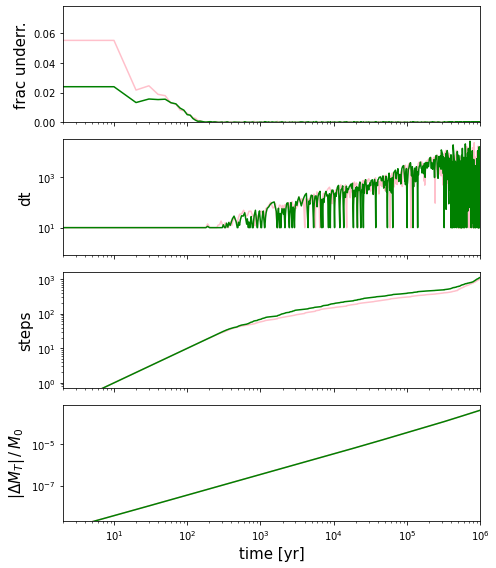

In [278]:
fig,ax=plt.subplots(4,figsize=(7,8),sharex=True)

ax[0].plot(ts1[:-1] ,bins_underr1/(gpe*gps),c='pink')
ax[0].plot(ts2[:-1] ,bins_underr2/(gpe*gps),c='g')
ax[0].set_ylim(0)
ax[0].set_ylabel('frac underr.',fontsize=15)

ax[1].plot(ts1[:-1] ,dt1,ls='-',marker='',markersize=2,c='pink')
ax[1].plot(ts2[:-1] ,dt2,ls='-',marker='',markersize=2,c='g')
ax[1].set_ylabel('dt',fontsize=15)
ax[1].set_ylim(1-.2*1,max(np.append(dt1,dt2))+.2*max(np.append(dt1,dt2)))

ax[2].plot(ts1 ,range(len(ts1)),ls='-',marker='',markersize=2,c='pink')
ax[2].plot(ts2 ,range(len(ts2)),ls='-',marker='',markersize=2,c='g')
ax[2].set_ylabel('steps',fontsize=15)
#ax[2].set_ylim(1,max(len(N1),len(N2))+.2*max(len(N1),len(N2)))

#ax[1].plot(frms,np.full(len(frms),80),ls='',marker="|",zorder=0)
#ax[2].plot(frms,np.full(len(frms),2e7),ls='',marker="|",zorder=0)

ax[3].plot(ts1 ,abs(total_mass_ts1 - total_mass_ts1[0]) / total_mass_ts1[0],ls='-',marker='',markersize=2,c='pink')
ax[3].plot(ts2 ,abs(total_mass_ts2 - total_mass_ts2[0]) / total_mass_ts2[0],ls='-',marker='',markersize=2,c='g')
ax[3].set_ylabel(r'$|\Delta M_T| \,/\,M_{0}$',fontsize=15)

for i in range(3):
    ax[i+1].set_yscale('log')

plt.subplots_adjust(hspace=0)
plt.xlim(2,(max(ts1[-1],ts2[-1]) + 20) )
plt.xscale('log')
plt.xlabel('time [yr]',fontsize=15)

fig.tight_layout()
plt.show()

In [279]:
def difference(n1, n2, ts1, ts2, time):
    step1 = np.argmin(np.abs(ts1 - time))
    step2 = np.argmin(np.abs(ts2 - ts1[step1]))    
    
    N_1 = 10**n1[step1]
    N_2 = 10**n2[step2]
    
    diff = (N_1 - N_2)/N_1
    absdiff = np.abs(N_1 - N_2)/N_1
    avg = np.nanmean(np.nan_to_num(absdiff,posinf=np.nan))
    med = np.nanmedian(absdiff)
    std = np.nanstd(absdiff)
    
    tdiff = ts1[step1] - ts2[step2]
    return diff, avg, med, std, tdiff

In [280]:
num_frms = 100
times_of_interest = np.logspace(3,6,num_frms)
diff = np.zeros((num_frms,gpe,gps))
davg = np.zeros(num_frms)
dmed = np.zeros(num_frms)
dstd = np.zeros(num_frms)
tdiff= np.zeros(num_frms)

for i in range(num_frms):
    diff[i], davg[i], dmed[i], dstd[i], tdiff[i] = difference(N1,N2,ts1,ts2,times_of_interest[i])

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_33945/106565939.py:8: RuntimeWarning: invalid value encountered in true_divide
  diff = (N_1 - N_2)/N_1
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_33945/106565939.py:8: RuntimeWarning: divide by zero encountered in true_divide
  diff = (N_1 - N_2)/N_1
/Users/mdodici/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_33945/971785381.py:10: RuntimeWarning: invalid value encountered in log10
  ax[2].plot(times_of_interest,np.log10(tdiff),ls='',marker='o',c='pink')
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_33945/971785381.py:11: RuntimeWarning: invalid value encountered in log10
  ax[2].plot(times_of_interest,np.log10(-tdiff),ls='',marker='o',c='g')


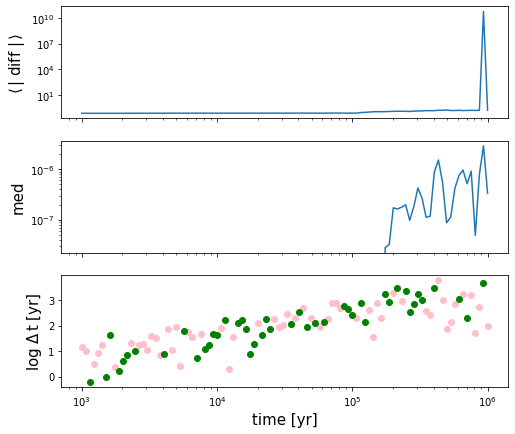

In [281]:
fig,ax=plt.subplots(3,figsize=(8,7),sharex=True)
ax[0].plot(times_of_interest,davg)
ax[0].set_ylabel(r'$\langle\,|$ diff $|\,\rangle$',fontsize=15)
ax[0].set_yscale('log')

ax[1].plot(times_of_interest,dmed)
ax[1].set_yscale('log')
ax[1].set_ylabel('med',fontsize=15)

ax[2].plot(times_of_interest,np.log10(tdiff),ls='',marker='o',c='pink')
ax[2].plot(times_of_interest,np.log10(-tdiff),ls='',marker='o',c='g')
ax[2].set_ylabel(r'log $\Delta\,$t [yr]',fontsize=15)
ax[2].set_xscale('log')
ax[2].set_xlabel('time [yr]',fontsize=15)
plt.show()

Pick 100 log-spaced times between 1000 and 1e6 years. Find the timestep from the "perfect" run that's closest to each time, and the timestep from the "test" run that's closest to the "perfect" run's time. At these, compare the values in each cell $i,j$. These will inherently be a little off, since the times don't match up perfectly, but ideally will be close. Taking the average of these discrepancies (specifically, for each cell, $|N^{i,j}_\text{perfect} - N^{i,j}_\text{test}|/N^{i,j}_\text{perfect}$), we an averaged difference for each timestep. Top panel shows this average, ignoring cells where discrepancy is infinite (i.e. $N^{i,j}_\text{perfect}= 0 \neq N^{i,j}_\text{test}$). Middle panel shows median of these discrepancies, which is 0 until the point where it appears on the plot. Bottom plot shows the difference in actual time of the steps being compared. Where pink, the actual time of the perfect run is greater than that of the test, and where green, the opposite.

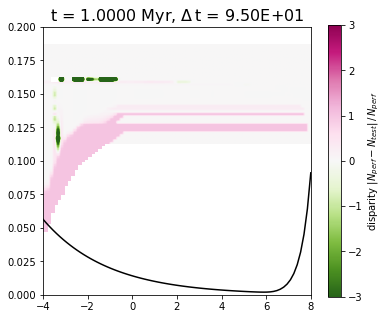

In [289]:
fig, ax = plt.subplots(figsize=(6,5))
ax.set_ylim(eMin,eMax)
ax.set_xlim(sMin,sMax)
ax.set_xlabel('log size [cm]',fontsize=16)
ax.set_ylabel('eccentricity',fontsize=16)
ax.set_xlim(sMin,sMax)
ax.set_ylim(eMin,eMax)

txt_title = ax.set_title('')
#ax.text(-3.6,.145,'Number per bin',fontsize=20,va='top')

im1 = ax.imshow(diff[0],origin='lower',extent=(sMin,sMax,eMin,eMax),aspect=asp_rat,cmap='PiYG_r',vmin=-3,vmax=3)
ax.plot(size,efail,c='k')

plt.colorbar(im1,ax=ax,label=r'disparity $|N_{perf} - N_{test}|\,/\,N_{perf}$')

def plot_flow(step):
    ax.clear()
    ax.imshow(diff[step],origin='lower',extent=(sMin,sMax,eMin,eMax),aspect=asp_rat,cmap='PiYG_r',vmin=-3,vmax=3)
    #ax.text(-3.6,.145,'Number per bin',fontsize=20,va='top')
    ax.set_title(r't = %.4f Myr, $\Delta\,$t = %1.2E' %(times_of_interest[step]/1e6, tdiff[step]),fontsize=16)
    ax.plot(size,efail,c='k')
    plt.xlim(sMin,sMax)
    plt.ylim(eMin,eMax)
    
N_ratio_anim = animation.FuncAnimation(fig, plot_flow, frames=num_frms, interval=100)
HTML(N_ratio_anim.to_html5_video())

When a cell is pink, $N^{i,j}_\text{perfect} > N^{i,j}_\text{test}$, and when green, the opposite.